# 게이트가 추가된 RNN



[1.9799028507612162, 2.948192230043497, 4.423974803652142, 6.632554898635134, 9.943930439705637, 14.90847523574834, 22.351590470283313, 33.51070957535689, 50.2410626452578, 75.32411003430748, 112.92996711762825, 169.31069570381544, 253.8397239578751, 380.570200784769, 570.5713647458688, 855.4313543116283, 1282.5088098582585, 1922.8063585390232, 2882.7749673288463, 4322.011665580401]


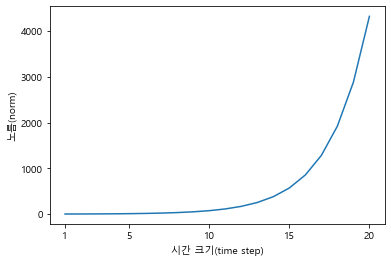

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager

N = 2 # 미니배치 크기
H = 3 # 은닉 상태 벡터의 차원 수
T = 20 # 시계열 데이터의 길이

dh = np.ones((N,H))
np.random.seed(3) # 재현할 수 있도록 난수의 시드 고정
Wh = np.random.rand(H, H)

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)
    
    
print(norm_list)


plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.rc('font', family='Malgun Gothic') # 폰트
plt.xlabel('시간 크기(time step)')
plt.ylabel('노름(norm)')
plt.show()

[0.9899514253806081, 0.7370480575108742, 0.5529968504565177, 0.4145346811646959, 0.31074782624080116, 0.2329449255585678, 0.17462180054908838, 0.13090120927873786, 0.09812707547901914, 0.0735587012053784, 0.05514158550665442, 0.04133561906831432, 0.03098629442845155, 0.023228161668992248, 0.01741245619951992, 0.013052846592889836, 0.009784765700212543, 0.007334924158245175, 0.005498456892640774, 0.004121791520672227]


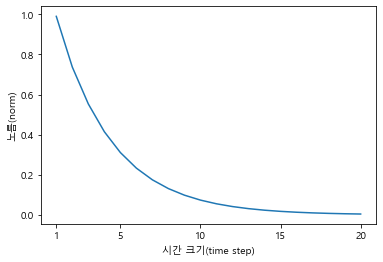

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager

N = 2 # 미니배치 크기
H = 3 # 은닉 상태 벡터의 차원 수
T = 20 # 시계열 데이터의 길이

dh = np.ones((N,H))
np.random.seed(3) # 재현할 수 있도록 난수의 시드 고정
Wh = np.random.rand(H, H) * 0.5

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)
    
    
print(norm_list)


plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.rc('font', family='Malgun Gothic') # 폰트
plt.xlabel('시간 크기(time step)')
plt.ylabel('노름(norm)')
plt.show()

In [11]:
# 기울기 클리핑
 

dW1 = np.random.rand(3,3) * 10
dW2 = np.random.rand(3,3) * 10
grads = [dW1,dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate
            
            

In [12]:
# LSTM 클래스

class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx,Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev, c_prev): # 순전파
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b
        
        # slice
        
        f = A[:, : H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f*c_prev + g * i
        h_next = o*np.tanh(c_next)
        
        self.cache = (x, h+prev, c_prev, i, f, g, o ,c_next)
        
        return h_next, c_next
        
        
        
        

In [18]:
# LSTM 계층을 사용하는 Rnnlm 클래스

import sys
sys.path.append('..')
from time_layers import * 
import pickle

class Rnnlm:
    def __init__(self, vocab_size = 10000, wordvec_size = 100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 가중치 초기화
        embed_W = (rn(V, D)/ 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) /np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout = 1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        
        return dout
    
    def reset_state(self):
        self.lstm_layer.reset_state()
        
        
    def save_params(self, file_name = 'Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
            
    def load_params(self, file_name = 'Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)
        


| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 9999.30
| 에폭 1 |  반복 21 / 1327 | 시간 5[s] | 퍼플렉서티 2790.24
| 에폭 1 |  반복 41 / 1327 | 시간 10[s] | 퍼플렉서티 1252.94
| 에폭 1 |  반복 61 / 1327 | 시간 16[s] | 퍼플렉서티 941.00
| 에폭 1 |  반복 81 / 1327 | 시간 21[s] | 퍼플렉서티 804.54
| 에폭 1 |  반복 101 / 1327 | 시간 26[s] | 퍼플렉서티 660.78
| 에폭 1 |  반복 121 / 1327 | 시간 31[s] | 퍼플렉서티 640.53
| 에폭 1 |  반복 141 / 1327 | 시간 37[s] | 퍼플렉서티 591.50
| 에폭 1 |  반복 161 / 1327 | 시간 43[s] | 퍼플렉서티 573.52
| 에폭 1 |  반복 181 / 1327 | 시간 50[s] | 퍼플렉서티 586.45
| 에폭 1 |  반복 201 / 1327 | 시간 57[s] | 퍼플렉서티 506.70
| 에폭 1 |  반복 221 / 1327 | 시간 64[s] | 퍼플렉서티 481.12
| 에폭 1 |  반복 241 / 1327 | 시간 71[s] | 퍼플렉서티 449.99
| 에폭 1 |  반복 261 / 1327 | 시간 78[s] | 퍼플렉서티 461.60
| 에폭 1 |  반복 281 / 1327 | 시간 85[s] | 퍼플렉서티 445.17
| 에폭 1 |  반복 301 / 1327 | 시간 92[s] | 퍼플렉서티 386.27
| 에폭 1 |  반복 321 / 1327 | 시간 99[s] | 퍼플렉서티 345.59
| 에폭 1 |  반복 341 / 1327 | 시간 106[s] | 퍼플렉서티 399.57
| 에폭 1 |  반복 361 / 1327 | 시간 112[s] | 퍼플렉서티 400.50
| 에폭 1 |  반복 381 / 1327 | 시간 118[s] | 퍼플렉서티 329.90
| 

| 에폭 3 |  반복 541 / 1327 | 시간 995[s] | 퍼플렉서티 135.88
| 에폭 3 |  반복 561 / 1327 | 시간 1003[s] | 퍼플렉서티 119.71
| 에폭 3 |  반복 581 / 1327 | 시간 1011[s] | 퍼플렉서티 107.01
| 에폭 3 |  반복 601 / 1327 | 시간 1019[s] | 퍼플렉서티 149.09
| 에폭 3 |  반복 621 / 1327 | 시간 1027[s] | 퍼플렉서티 142.77
| 에폭 3 |  반복 641 / 1327 | 시간 1035[s] | 퍼플렉서티 129.17
| 에폭 3 |  반복 661 / 1327 | 시간 1043[s] | 퍼플렉서티 120.91
| 에폭 3 |  반복 681 / 1327 | 시간 1051[s] | 퍼플렉서티 99.80
| 에폭 3 |  반복 701 / 1327 | 시간 1059[s] | 퍼플렉서티 119.14
| 에폭 3 |  반복 721 / 1327 | 시간 1067[s] | 퍼플렉서티 126.44
| 에폭 3 |  반복 741 / 1327 | 시간 1075[s] | 퍼플렉서티 107.36
| 에폭 3 |  반복 761 / 1327 | 시간 1083[s] | 퍼플렉서티 103.82
| 에폭 3 |  반복 781 / 1327 | 시간 1092[s] | 퍼플렉서티 104.59
| 에폭 3 |  반복 801 / 1327 | 시간 1100[s] | 퍼플렉서티 116.02
| 에폭 3 |  반복 821 / 1327 | 시간 1108[s] | 퍼플렉서티 115.07
| 에폭 3 |  반복 841 / 1327 | 시간 1116[s] | 퍼플렉서티 114.60
| 에폭 3 |  반복 861 / 1327 | 시간 1124[s] | 퍼플렉서티 120.80
| 에폭 3 |  반복 881 / 1327 | 시간 1133[s] | 퍼플렉서티 107.53
| 에폭 3 |  반복 901 / 1327 | 시간 1141[s] | 퍼플렉서티 132.77
| 에폭 3 |  반복 9

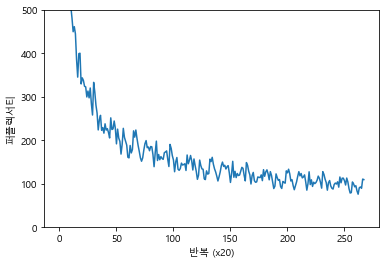

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼블렉서티 :  136.17817017668767


In [19]:
# PTB 데이터셋 학습

import sys
sys.path.append('..')
from optimizer import SGD
from trainer import RnnlmTrainer
from util import eval_perplexity
import pbt


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 35 # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = pbt.load_data('train')
corpus_test, _, _ = pbt.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용해 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0,500))
# 20번재 반복마다 퍼블렉서티를 평가
# 데이터가 크기 때문에 모든 에폭에서 평가하지 않고, 20번 반복될 때마다 평가

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼블렉서티 : ', ppl_test)
# 테스트 데이터를 이용해 퍼블렉서티 평가
# 모델 상태 LSTM의 은닉 상태와 기억 셀를 재설정해 평가를 수행


# 매개변수 저장
model.save_params()



In [22]:
# 기울기 구하기
model.forward(...)
model.backward(...)
params, grads = model.params, model.grads

# 기울기 클리핑
if max_grad is not None:
    clip_grads(grads, max_grad)

# 매개변수 갱신
optimizer.update(params, grads)


SyntaxError: invalid syntax (<ipython-input-22-62fa7feb08a2>, line 2)

In [42]:
# BetterRnnlm 클래스

import sys
sys.path.append('..')
from time_layers import *
from np import *
from base_model import BaseModel

class BetterRnnlm(BaseModel):
    def __init__(self, vocab_size = 10000, wordvec_size=650, hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
    
        embed_W = (rn(V, D)/ 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H)/np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H)/np.sqrt(H)).astype('f')
        lstm_b1 =  np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H)/np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H)/np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4*H).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        
        # 세 가지 개선
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b) # 가중치 공유
            
            
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2],self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, xs, train_flag = False):
        for layer in self.drop_layers:
            layer.train_flg = train_flag
            
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()
        

In [47]:
import sys
sys.path.append('..')
import config

from optimizer import SGD
from trainer import RnnlmTrainer
from util import eval_perplexity
import pbt

config.GPU = True
# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = pbt.load_data('train')
corpus_val, _, _ = pbt.load_data('val')
corpus_test, _, _ = pbt.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

| 에폭 1 |  반복 1 / 1327 | 시간 3[s] | 퍼플렉서티 10000.11
| 에폭 1 |  반복 21 / 1327 | 시간 55[s] | 퍼플렉서티 4937.66
| 에폭 1 |  반복 41 / 1327 | 시간 106[s] | 퍼플렉서티 1897.79


KeyboardInterrupt: 